<a href="https://colab.research.google.com/github/alexandruxtrifon/SMSSpamCollection/blob/main/SMSSpamCollection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [33]:
# incarc dataset-ul
df = pd.read_csv('SMSSpamCollection', delimiter='\t', header=None, names=['label', 'message'])
# atribui valoare binara la label
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [34]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text
df['message'] = df['message'].apply(clean_text)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah think goes usf lives around though


In [35]:
df['label'].value_counts()

label
0    4825
1     747
Name: count, dtype: int64

In [36]:
# pregatesc datele
X = df['message'].values
y = df['label'].values

In [37]:
# voi utiliza metoda cu tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)
print(X)

[[   0    0    0 ...   13 3781   64]
 [   0    0    0 ...  347    1 1670]
 [   0    0    0 ...  278   53  279]
 ...
 [   0    0    0 ...    0    0 1116]
 [   0    0    0 ...  858  115    9]
 [   0    0    0 ... 2291  322  149]]


In [38]:
# construirea si antrenarea retelei neuronale CNN - convolutional
model = Sequential([
    Embedding(input_dim=5000, output_dim=50, input_length=100),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
#antrenare
history = model.fit(X, y, epochs=10, validation_split=0.2, batch_size=32)


Epoch 1/10
140/140 [==============================] - 3s 13ms/step - loss: 0.4989 - accuracy: 0.8335 - val_loss: 0.3312 - val_accuracy: 0.8700
Epoch 2/10
140/140 [==============================] - 2s 15ms/step - loss: 0.2833 - accuracy: 0.9067 - val_loss: 0.1015 - val_accuracy: 0.9731
Epoch 3/10
140/140 [==============================] - 2s 12ms/step - loss: 0.1396 - accuracy: 0.9538 - val_loss: 0.0629 - val_accuracy: 0.9794
Epoch 4/10
140/140 [==============================] - 1s 9ms/step - loss: 0.1031 - accuracy: 0.9619 - val_loss: 0.0500 - val_accuracy: 0.9874
Epoch 5/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0734 - accuracy: 0.9726 - val_loss: 0.0528 - val_accuracy: 0.9857
Epoch 6/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0521 - accuracy: 0.9834 - val_loss: 0.0579 - val_accuracy: 0.9821
Epoch 7/10
140/140 [==============================] - 1s 10ms/step - loss: 0.0367 - accuracy: 0.9883 - val_loss: 0.0566 - val_accuracy: 0.9857
Ep

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# predictia

y_pred = model.predict(X).ravel()

# calculare scor auc roc

auc_roc = roc_auc_score(y, y_pred)
print(f"AUC ROC Score: {auc_roc}")

175/175 [==============================] - 1s 4ms/step
AUC ROC Score: 0.9992698947777292


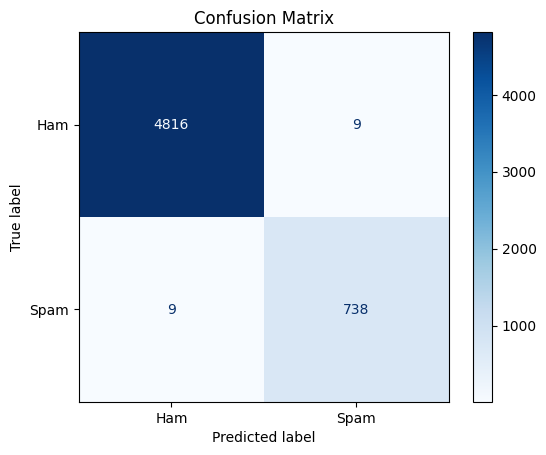

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# convertesc probabilitatile in predictii binare
y_pred_binary = (y_pred >= 0.5).astype(int)

# generez confusion matric
cm = confusion_matrix(y, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

# fac plot la confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

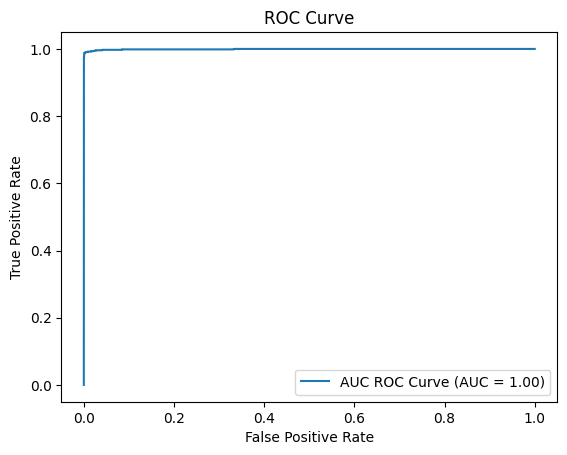

In [42]:
#plot roc curve
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, label=f"AUC ROC Curve (AUC = {auc_roc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

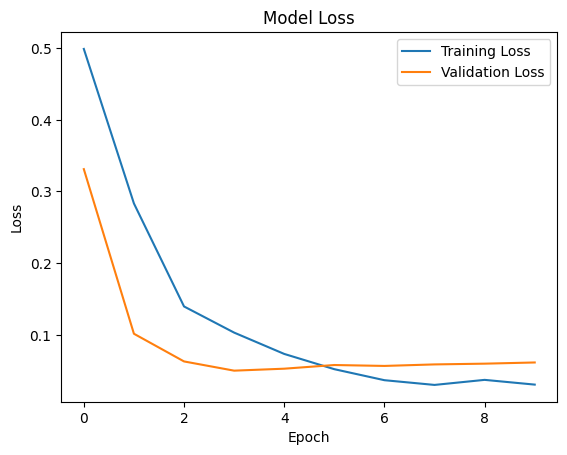

In [43]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

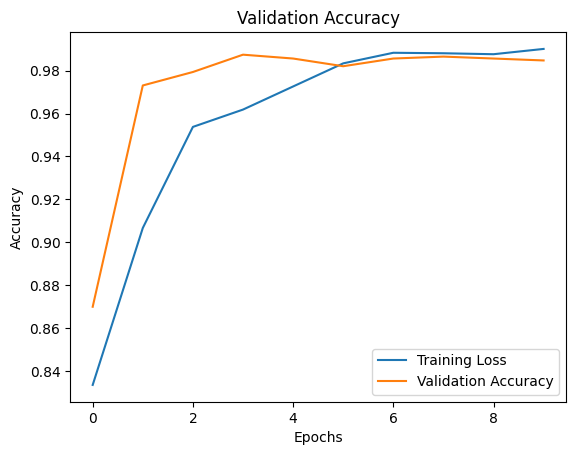

In [44]:
plt.plot(history.history['accuracy'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

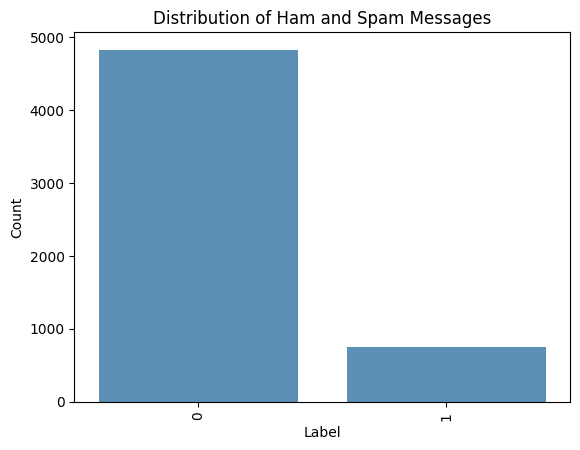

In [45]:
import seaborn as sns
# distributia ham si spam
label_counts = df['label'].value_counts()
plt.figure()
label_names = ['Ham', 'Spam']
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Messages')
plt.xticks(rotation=90)
plt.show()